In [1]:
import altair as alt
import os
import pandas as pd
import scipy.io

from simulation_viz.simulation_viz.import_simulation_data import load_simulation, gather_flux_data, gather_conc_data, aggregate_time_series
from simulation_viz.simulation_viz.check_simulations import check_for_negative_concentrations, get_non_converging_models, remove_models
from simulation_viz.simulation_viz.visualize_simulations import plot_ensemble, plot_model
from simulation_viz.simulation_viz.visualize_simulations_interactive import plot_ensemble_interactive, plot_model_interactive
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

**If you have a large simulation file, e.g. over 100MB please use the notebook "visualize_simulations_large" or you might run out of memory.**

### Define path to the folder that contains the simulation results and model ensemble

In [2]:
raw_data_dir = '../io/output'

### Define the model name

In [3]:
model_name = 'toy_model'

### Define the simulation name

In [4]:
simulation_name = 'toy_model'

### Define number of models to be simulated

In [5]:
n_models = 5

### Load and process data

In [6]:
mat, ref_conc_dic, ref_flux_dic, met_names, rxn_names = load_simulation(raw_data_dir, model_name, simulation_name, n_models)

To get absolute concentrations set conc_type='conc_abs', to get relative concentrations set conc_type='conc_rel'.

To get absolute fluxes set flux_type='flux_abs', to get relative fluxes set flux_type='flux_rel'.

In [7]:
conc_type = 'conc_abs'
flux_type = 'flux_abs'

In [8]:
conc = gather_conc_data(mat, met_names, n_models, conc_type, ref_conc_dic=ref_conc_dic)

total time: 0.01753520965576172
There were a total of 0 missing models out of 5.


In [9]:
flux = gather_flux_data(mat, rxn_names, n_models, flux_type, ref_flux_dic=ref_flux_dic)

total time: 0.02545642852783203
There were a total of 0 missing models out of 5.


### Check and filter out models

Check for negative concentrations

In [10]:
check_for_negative_concentrations(conc, conc_type, threshold=-10**-8)

All concentrations are above the treshold -1e-08 :)


Check for non converging models

In [11]:
quant_type = 'conc_abs'
non_converging_models = get_non_converging_models(conc, n_models, met_names, conc_type, rel_tol=5*10**-3)
non_converging_models

[1, 3]

Remove non-converging models

In [12]:
conc_filtered, flux_filtered = remove_models(conc, flux, non_converging_models)   

### Aggregate simulation results into median, 1st and 3rd quartile

In [13]:
conc_quartiles_df = aggregate_time_series(conc_filtered, conc_type, met_names)    

flux_quartiles_df = aggregate_time_series(flux_filtered, flux_type, rxn_names)   

### Plot results with matplotlib

To plot absolute concentrations set quant_type='conc_abs', to plot relative concentrations set quant_type='conc_rel'.

To plot absolute fluxes set quant_type='flux_abs', to plot relative fluxes set quant_type='flux_rel'.

#### Plot results for a given model

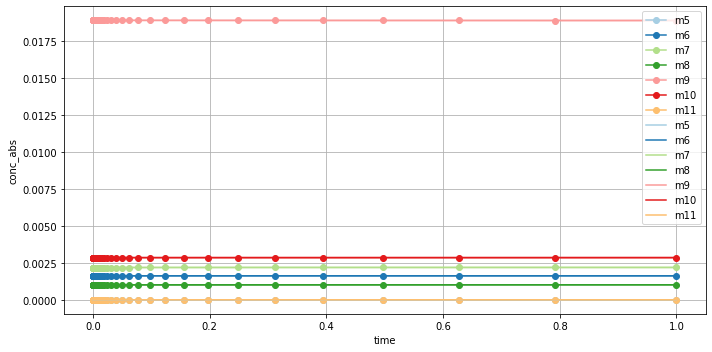

In [14]:
plot_model(conc, model_i=1, quant_type=conc_type,
           selected_data=met_names,  x_scale='linear', y_scale='linear', x_lim=None,
            y_lim=None, fig_size=None, save_plot=False, output_file=None)

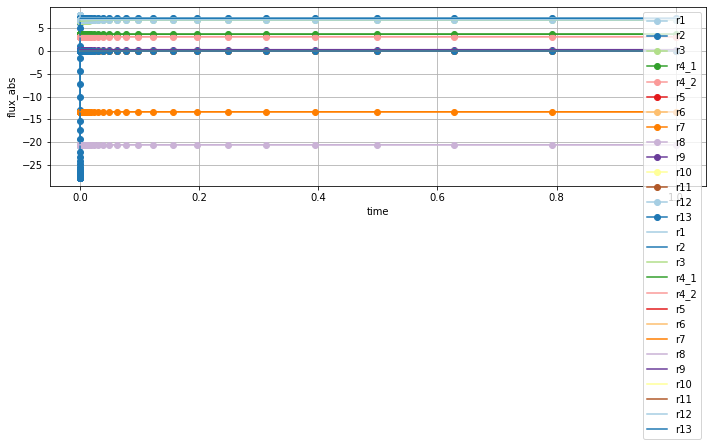

In [15]:
plot_model(flux, model_i=1, quant_type=flux_type,
           selected_data=rxn_names,  x_scale='linear', y_scale='linear', x_lim=None,
            y_lim=None, fig_size=None, save_plot=False, output_file=None)

#### Plot summarized results for whole ensemble

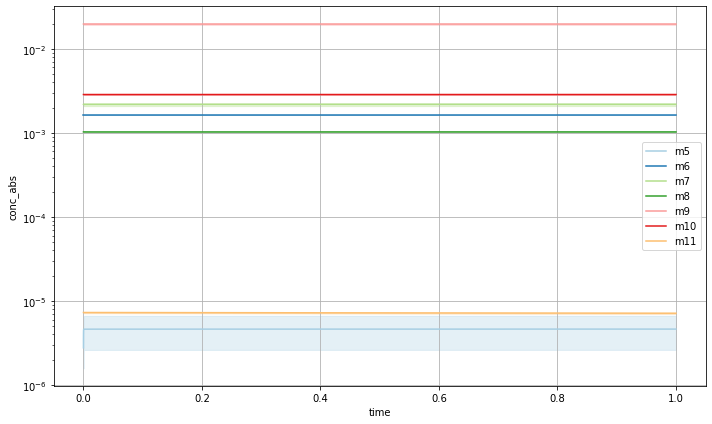

In [16]:
x_lim = None
y_lim = None

plot_ensemble(conc_quartiles_df, quant_type=conc_type, selected_data=[met_names], x_scale='linear',
              y_scale='log', x_lim=x_lim, y_lim=y_lim, fig_size=(10,6), save_plot=False, output_file=None)

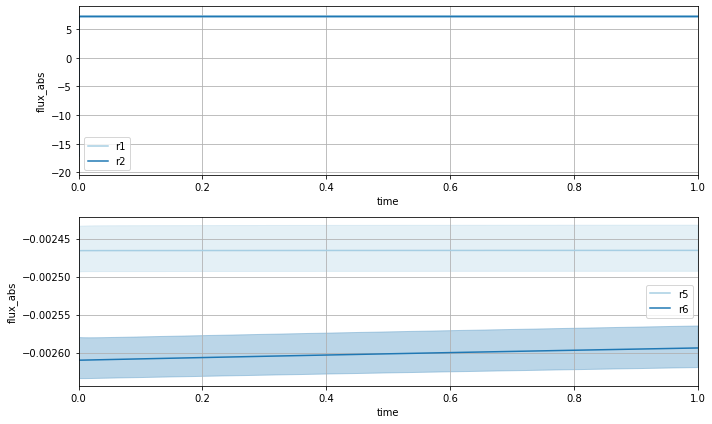

In [17]:
x_lim = [0, 1]
y_lim = None

plot_ensemble(flux_quartiles_df, quant_type=flux_type, selected_data=[['r1', 'r2'], ['r5', 'r6']], x_scale='linear',
              y_scale='linear', x_lim=x_lim, y_lim=y_lim, fig_size=(10,6), save_plot=False, output_file=None)

### Plot results with altair

To plot absolute concentrations set quant_type='conc_abs', to plot relative concentrations set quant_type='conc_rel'.

To plot absolute fluxes set quant_type='flux_abs', to plot relative fluxes set quant_type='flux_rel'.

#### Plot results for a given model

In [18]:
plot_model_interactive(conc, model_i=2, quant_type=conc_type,
                       selected_data=met_names, x_scale='linear',
                       y_scale='log', x_lim=[0,1], y_lim=None)

alt.LayerChart(...)

In [19]:
plot_model_interactive(flux, model_i=2, quant_type=flux_type,
                       selected_data=rxn_names, x_scale='linear',
                       y_scale='linear', x_lim=[0,1], y_lim=None)

alt.LayerChart(...)

#### Plot summarized results for whole ensemble

In [20]:
plot_ensemble_interactive(conc_quartiles_df, quant_type=conc_type, selected_data=met_names, x_scale='linear',
                          y_scale='log', x_lim=None, y_lim=None)

alt.LayerChart(...)

In [21]:
plot_ensemble_interactive(flux_quartiles_df, quant_type=flux_type, selected_data=rxn_names, x_scale='linear',
                          y_scale='linear', x_lim=None, y_lim=None)

alt.LayerChart(...)